# What is the problem?

The world is facing an unprecedented crisis due to the **COVID-19** pandemic. Being able to test patients for COVID rapidly is crucial to all containment efforts. However, not all countries and municipalities have the resources to rapidly test all patients, especially when the healthcare system is overwhelmed with patients, e.g., during a signiﬁcant spike in coronavirus cases.

Therefore, **imaging has been proposed as a way to complement existing methods for COVID testing**, especially **in “low-resource” situations**

The aim of this project is to accurately classify ultrasound lungs images into **three categories, namely, COVID-19 infected, pneumonia infected, and healthy lungs**.

<p align="center">
	<img src="../../images/ultrasound_lung_images.png" alt="photo not available" width="70%" height="70%">
	<br>
   <em>Example lung ultrasound images. (A): A typical COVID-19 infected lung, showing small subpleural consolidation and pleural irregularities. (B): A pneumonia infected lung, with dynamic air bronchograms surrounded by alveolar consolidation. (C) Healthy lung. 
The lung is normally aerated with horizontal A-lines. Image and caption from Born et. al. 2020</em>
</p>

### Why would deep learning solve this?
Deep learning has emerged in recent years as one of the best ways to classify images, as long as there is enough training data. Fortunately (or unfortunately, depending on your perspective), the number of training images for COVID is currently growing as the pandemic continues to spread. Therefore, **a deep learning based approach not only has the potential to be effective but would also become more promising in terms of classification performance as time goes on since more training data will become available**. 

# Setup

Let us first **install the required libraries**

In [2]:
!pip install -r ../../requirements.txt

Now, we will **import all the required libraries**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image
import cv2

import os
import random
from imutils import paths
from collections import defaultdict 
import numpy as np
import time
import argparse
import itertools

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

### Fixing Random Seeds

We fix radnom seeds to ensure reproducibility of results

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Initializing parameters

Here, we **initialise all the parameters as Global variables** required at various places in this notebook. These parameters can also be passed in as command line arguments in the [train.py](https://github.com/ar-ambuj23/covid19_pocus_ultrasound_pytorch/blob/main/code/scripts/train.py) script

In [3]:
CROSS_VAL_DIR = '../data/cross_validation'
MODEL_SAVE_DIR = '../trained_models'
N_EPOCHS = 20
FOLD = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 1e-5
BATCH_SIZE = 20
IMG_WIDTH, IMG_HEIGHT = 224, 224
MODEL_NAME = 'vgg16'
OUTPUTS_SAVE_DIR = os.path.join('../outputs', MODEL_NAME)

## In this notebook we will implement the Image Classification for detecting Covid infected, Pneumonia infected and Healthy lungs using VGG16 model.

**VGG** is a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in 2014.

VGG is not a single model, but a family of models that are all similar but have different *configurations*. Each configuration specifies the number of layers and the size of each layer. The configurations are listed in table 1 of the [VGG paper](https://arxiv.org/pdf/1409.1556.pdf) and denoted by a letter, although recently they are just referred to as the number of layers with weights in the model, e.g. configuration "A" has 11 layers with weights so is known as VGG11.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/vgg-table.png?raw=1)

## Below is the architecture of configuration "D", also known as VGG16, for a 224x224 color image.

![](../../images/vgg16.png)

## Network Architecture used here

- Here, we use only the convolutional part of VGG-16. 
- It is followed by **one hidden layer of 64 neurons with ReLU activation, dropout of 0.5 and batch normalization and further by the output layer with softmax activation.**

Now, we will define a Pytorch model class for our custom VGG16 architecture

## The VGG16 Model

In [4]:
class VGG16_model(nn.Module):
    def __init__(self,
                 input_size: tuple = (3, 224, 224),
                 hidden_size: int = 64,
                 dropout: float = 0.5,
                 num_classes: int = 3,
                 **kwargs
                ):
        """
        Initialize a new network
        
        Inputs: 
        - input_size: Tuple, size of input data
        - hidden_size: Integer, number of units to use in hidden layer
        - dropout: Float, dropout coefficient
        - num_classes: Integer, number of classes
        """
        
        super(VGG16_model, self).__init__()
        
        # load the VGG16 network
        self.model = models.vgg16(pretrained=True)

        # freeze weights of base model except last cnn layer
        # model.parameters() does not include max pooling layers
        last_frozen = 25
        count = 0
        for param in self.model.parameters():
            count += 1
            if count < last_frozen:
                param.requires_grad = False
                
        # Taking only sequential part
        self.model = self.model.features
    
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        x = self.model(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        xstar = self.fc1(x)
        x = self.bn(xstar) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x, xstar

# Dataset

### Source of the Dataset

We will be using the dataset provided by the authors of the original **POCOVID-Net paper**. This dataset is freely available on GitHub [3].

### Description of the Dataset

* The dataset consists of images (obtained from videos) which are labeled into the following three categories
    - COVID-19 infected
    - Pneumonia infected
    - Healthy
* The images and videos are recorded by an ultrasound transducer, also called a probe, which is a device that produces sound waves that bounce off body tissues and make echoes.
* The linear probe is a higher frequency probe yielding more superﬁcial images.
* Depending on the type of probe, there are two types of data (*paraphrased from the authors* [3])
  1. **Convex Probe**
     - 162 videos (46x COVID, 49x bacterial pneumonia, 64x healthy, 3x viral pneumonia)
     - 20 videos from the Butterﬂy dataset (18 COVID, 2 healthy, see below how to use the provided scripts to process the data)
     - 53 images (18x COVID, 20x bacterial pneumonia, 15x healthy)
  2. **Linear Probe**
     - 20 videos (6x COVID, 2x bacterial pneumonia, 9x healthy, 3x viral pneumonia)
     - 6 images (4x COVID, 2x bacterial pneumonia)
     - 45 videos of possible COVID-19 patients collected in Piacenza at the peak of the crisis in Italy; there were not enough PCR tests available, so the label is not clear. For more information and comments by medical experts, see the [metadata sheet](https://docs.google.com/spreadsheets/d/1t-tLMjMod6W-nAjkuxmO0CLsiyalFIOp92k_XD_yeo8/edit#gid=1181682638) or [metadata csv](https://github.com/jannisborn/covid19_pocus_ultrasound/blob/master/data/dataset_metadata.csv).

We will load our data using the **Torch Dataset Class** as shown below

## The Pocovid Dataset Class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Our custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our Pocovid dataset. **This is memory efficient because all the images are not
stored in the memory at once but read as required.**

Sample of our dataset will be a dict
``[{image_tensor}, {image_class}]``. Our datset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample.

In [5]:
class PocovidDataset(Dataset):
    """Subclass of Dataset for POCOVID-Net data"""
  
    def __init__(self, data_path_info, transform=None):
        """
        Args:
          data_path_info (dict): Dictionary containing the paths and labels for images
          transform (callable, optional): Optional transform to be applied
              on a sample.
        """
        self.__transform = transform
        
        self.__covid_class = 0
        self.__pneu_class = 1
        self.__regular_class = 2

        covid_items = []
        pneu_items = []
        regular_items = []

        for i in range(len(data_path_info['path_list'])):
            if(data_path_info['label_list'][i] == 'covid'):
                covid_items.append(data_path_info['path_list'][i])
            elif(data_path_info['label_list'][i] == 'pneumonia'):
                pneu_items.append(data_path_info['path_list'][i])
            else:
                regular_items.append(data_path_info['path_list'][i])

        num_covid = 0
        num_pneu = 0
        num_regular = 0 
        
        self.__img_info = []
        for covid_filename in covid_items: 
            image = Image.open(covid_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((covid_filename,self.__covid_class))
                num_covid += 1
            
        for pneu_filename in pneu_items:
            image = Image.open(pneu_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((pneu_filename,self.__pneu_class))
                num_pneu += 1
                
        for regular_filename in regular_items:
            image = Image.open(regular_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((regular_filename,self.__regular_class)) 
                num_regular += 1

        self.__transform = transform
        self.__num_images = num_covid + num_pneu + num_regular
  
    def __len__(self):
        return self.__num_images
  
    def __getitem__(self,idx):
        img_path, img_class = self.__img_info[idx]
        image = Image.open(img_path)
        sample = [image, img_class, img_path]

        if self.__transform:
            sample = [self.__transform(image), img_class, img_path]

        return sample
    
    def get_covid_class_idx(self):
        return self.__covid_class
    
    def get_pneu_class_idx(self):
        return self.__pneu_class
    
    def get_regular_class_idx(self):
        return self.__regular_class
    
    def get_class_map(self):
        class_map = {self.get_covid_class_idx() : 'covid',
            self.get_pneu_class_idx() : 'pneumonia',
            self.get_regular_class_idx() : 'regular'}
        return class_map

#### Now that we have the dataset and the model all set up, we are ready to implement the training and test our model.

In the next section, we implement a **Training Class** which deals with all the training functionality of the model. The start_training function of this class will setup everything needed for the model and will start the training.

# The Training Class

In [6]:
class Trainer():
    
    def __init__(self, model_name=MODEL_NAME, lr=LR, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, 
                 image_width=IMG_WIDTH, image_height=IMG_HEIGHT, cross_val_dir=CROSS_VAL_DIR,
                model_save_dir=MODEL_SAVE_DIR, fold=FOLD):
        
        if(model_name=='vgg16'):
            self.model = VGG16_model().to(device)
        elif(model_name=='resnet18'):
            self.model = resnet18_model().to(device)
        else:
            print('Select models from the following:\n 1) vgg16\n 2) resnet50')
                    
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.fold = fold
        self.cross_val_dir = cross_val_dir
        
        self.image_width = image_width
        self.image_height = image_height
        
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(params = self.model.parameters(), lr=self.lr) #experiment with weigth_decay
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.95) # use scheduler
        
        self.model_save_dir = model_save_dir
        self.model_name = model_name
        
        self.train_loader = None
        self.test_loader = None
        
        self.classes = None
        self.class_map = None
        
        
    def get_train_test_info(self):
        """
        Get information dictionaries for train and test data
        Return - A dictionary with the following format
        {
        'path_list' : list of all image paths
        'label_list': list of the labels corresponding to each image path
        }
        
        """
    
        imagePaths = list(paths.list_images(self.cross_val_dir))

        train_path_info = defaultdict(list)
        test_path_info = defaultdict(list)

        for imagePath in imagePaths:
            path_parts = imagePath.split(os.path.sep)
            fold_number = path_parts[-3][-1]
            label = path_parts[-2]
            if(fold_number==str(self.fold)):
                test_path_info['path_list'].append(imagePath)
                test_path_info['label_list'].append(label)
            else:
                train_path_info['path_list'].append(imagePath)
                train_path_info['label_list'].append(label)

        return train_path_info, test_path_info
    
    
    def get_train_test_loaders(self, num_workers=2):
        
        """
        Get the train and test data according to the fold
        The fold passed in the constructor is selected as the test data 
        and the remaining folds are selected as the train data
        Returns - Train and Test Loaders 
        """
        
        train_path_info, test_path_info = self.get_train_test_info()

        train_transform = transforms.Compose([transforms.Resize((self.image_width, self.image_height)),
                                           transforms.RandomAffine(10,translate=(0.1,0.1)),
                                           transforms.ToTensor()])

        test_transform = transforms.Compose([transforms.Resize((self.image_width, self.image_height)),
                                           transforms.ToTensor()])

        trainset = PocovidDataset(train_path_info, transform = train_transform)
        testset = PocovidDataset(test_path_info, transform = test_transform)
        
        self.class_map = trainset.get_class_map()
        self.classes = [self.class_map[key] for key in sorted(self.class_map)]

        train_loader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, shuffle=True,
                                          batch_size=self.batch_size, drop_last=True)

        test_loader = torch.utils.data.DataLoader(testset, num_workers=num_workers, shuffle=True,
                                        batch_size=self.batch_size)
        
        return train_loader, test_loader
    
    def train(self, iterator):
        """
        The train function
        """
    
        self.model.train()

        epoch_loss = 0

        for i, batch in enumerate(iterator):

            inputs, labels = batch[0].to(device), batch[1].to(device)

            self.optimizer.zero_grad()

            outputs ,_ = self.model(inputs)

            loss = self.criterion(outputs, labels)

            loss.backward()

            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(iterator)

    def evaluate(self, iterator):
        """
        The eval function
        """
    
        self.model.eval()

        epoch_loss = 0

        with torch.no_grad():    
            for i, batch in enumerate(iterator):    

                inputs, labels = batch[0].to(device), batch[1].to(device)

                outputs,_ = self.model(inputs)

                loss = self.criterion(outputs, labels)

                epoch_loss += loss.item()

        return epoch_loss / len(iterator)
    
    def epoch_time(self, start_time, end_time):
        """
        The utility function to measure the time taken by an epoch to run
        """
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    def training(self):
        """
        The training function which does the training by calling train and eval functions
        """
    
        best_valid_loss = np.inf
        c = 0
        
        self.train_loader, self.test_loader = self.get_train_test_loaders()
        
        # Create the model save dir if it already doesn't exist
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)
        
        for epoch in range(self.n_epochs):

            print(f'Epoch: {epoch+1:02}')

            start_time = time.time()

            train_loss = self.train(self.train_loader)
            valid_loss = self.evaluate(self.test_loader)

            epoch_mins, epoch_secs = self.epoch_time(start_time, time.time())

            c+=1
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(self.model.state_dict(), os.path.join(self.model_save_dir, '{}_trained.pt'.format(self.model_name)))
                c=0

            if c>4:
                #decrease lr if loss does not decrease after 5 steps
                self.scheduler.step()
                c=0

            print(f'Time: {epoch_mins}m {epoch_secs}s') 
            print(f'Train Loss: {train_loss:.3f}')
            print(f'Val   Loss: {valid_loss:.3f}')
            print('-'*100)
        print(best_valid_loss)
        
    def evaluate_model(self, iterator=None, proba=False, one_batch=False):
        
        """
        This function is used for evaluating the results of a trained model on the test data
        Passing proba = True will also give the probabilities of the predictions
        Passing one_batch = True will give the results for just one batch
        """
        
        if iterator is None:
            iterator = self.test_loader
    
        self.model.eval()

        images = []
        true_labels = []
        pred_labels = []
        pred_probs = []

        with torch.no_grad():    
            for i, batch in enumerate(iterator):    

                inputs, labels = batch[0].to(device), batch[1].to(device)

                outputs,_ = self.model(inputs)

                y_prob = F.softmax(outputs, dim = -1)

                top_preds = y_prob.argmax(1, keepdim = True)

                images.append(inputs.to(device))
                true_labels.append(labels.to(device))
                pred_labels.append(top_preds.to(device))
                pred_probs.append(y_prob.to(device))

                if(one_batch):
                    break

        images = torch.cat(images, dim=0)
        true_labels = torch.cat(true_labels, dim=0)
        pred_labels = torch.cat(pred_labels, dim=0)
        pred_probs = torch.cat(pred_probs, dim=0)

        if(proba):
            return images, true_labels, pred_labels, pred_probs

        return images, true_labels, pred_labels
    
    def visualize_test_samples(self):
        
        """
        A utility function to visualise the predictions of the model on 1 batch of images
        """
    
        images, true_labels, pred_labels, pred_probs = self.evaluate_model(proba=True, one_batch=True)

        true_labels = true_labels.cpu().numpy()
        pred_labels = pred_labels.cpu().numpy()
        pred_probs = pred_probs.cpu().numpy()


        rows = int(np.sqrt(len(images)))
        cols = int(np.sqrt(len(images)))

        fig = plt.figure(figsize = (25, 20))

        for i in range(rows*cols):

            ax = fig.add_subplot(rows, cols, i+1)

            image, true_label, pred_label, pred_prob = images[i], true_labels[i], pred_labels[i], pred_probs[i]
            image = image.permute(1, 2, 0)
            ax.imshow(image.cpu().numpy())
            ax.set_title(f'true label: {self.class_map[true_label]}\n' \
                        f'pred label: {self.class_map[pred_label[0]]} (Prob: {max(pred_prob):.3f})',
                        color = ('green' if true_label==pred_label[0] else 'red'))
            ax.axis('off')

        fig.subplots_adjust(hspace = 0.4)
        plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'test_sample_result.png'))
        plt.show()
        
    def start_training(self):
        """
        To start trainig and return the trained model
        """
        self.training()
        return self.model

The next section implements the **Trained Model Class** which would be used to load an already trained model

# The Trained Model Class

In [7]:
class TrainedModel():
    
    def __init__(self, model_name='vgg16'):
        """
        To get the details of the pre-trained model
        """
        trainer = Trainer(model_name=model_name)
        self.model = trainer.model
        self.model_save_dir = trainer.model_save_dir
        self.model_name = model_name
        
    def loadModel(self):
        """
        To load the pre trained model
        """
        self.model.load_state_dict(torch.load(os.path.join(self.model_save_dir, '{}_trained.pt'.format(self.model_name)), map_location=torch.device(device)))
        trainer.model = self.model
        trainer.train_loader, trainer.test_loader = trainer.get_train_test_loaders()
        return self.model
    
    def countParameters(self):
        """
        To get the number of trainable parameters of the model
        """
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    def printModel(self):
        """
        To print the network architecture
        """
        print(self.model)

The next section implements the **Metrics Class** which has all the functions for different metrics we use later in the notebook

## The Metrics Class

In [8]:
class Metrics():
    
    def __init__(self, images, true_labels, pred_labels, pred_probs, classes):

        self.images = images
        self.true_labels = true_labels
        self.pred_labels = pred_labels
        self.pred_probs = pred_probs
        self.classes = classes
        
        # Create the output save dir if it already doesn't exist
        if not os.path.exists(OUTPUTS_SAVE_DIR):
            os.makedirs(OUTPUTS_SAVE_DIR)
        
    def plot_confusion_matrix(self):
        """To plot the confusion matrix"""
        fig = plt.figure(figsize = (10, 10));
        ax = fig.add_subplot(1, 1, 1);
        cm = self.get_confusion_matrix()
        cm = ConfusionMatrixDisplay(cm, display_labels = self.classes);
        cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
        plt.xticks(rotation = 20)
        plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'confusion_matrix.png'))
        plt.show()
    
    def get_confusion_matrix(self):
        """To get the confusion matrix"""
        cm = confusion_matrix(self.true_labels.cpu().numpy(), self.pred_labels.cpu().numpy())
        return cm
        
    def get_classification_report(self):
        """To get the Classification Report"""
        cr = classification_report(self.true_labels.cpu().numpy(), self.pred_labels.cpu().numpy(), target_names=self.classes)
        return cr
    
    def plot_roc_curve(self):
        """To plot the ROC Curve"""
        # Based off example from: 
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y = label_binarize(self.true_labels.cpu().numpy(), classes=[0, 1, 2])
        for i in range(len(self.classes)):
            fpr[i], tpr[i], _ = roc_curve(y[:, i], self.pred_probs.cpu().numpy()[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), self.pred_probs.cpu().numpy().ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(self.classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(self.classes)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= len(self.classes)

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(20,15))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                     ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                     ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        
        for i, color in zip(range(len(self.classes)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(self.classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right", prop={'size': 15})
        plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'roc_curve.png'))
        plt.show()

We have set up everything that is needed to run the training. **Let us now visualise the data and train the model**

# Visualizing a sample of Data

In [14]:
# Fetch sample input
# Don't augment this data becuase we want to see how the neural network behaves with real data as input.
trainer = Trainer()
train_path_data, test_path_data = trainer.get_train_test_info()
vis_transform = transforms.Compose([transforms.Resize((trainer.image_width, trainer.image_height)),
                                    transforms.ToTensor()])

visset = PocovidDataset(test_path_data, transform = vis_transform)

In [15]:
dataloader = torch.utils.data.DataLoader(visset, batch_size=4, shuffle=True, num_workers=2)

In [18]:
covid_idx = visset.get_covid_class_idx();
pneu_idx = visset.get_pneu_class_idx();
regular_idx = visset.get_regular_class_idx();
lbl_map = {covid_idx:"COVID",pneu_idx:"Pneumonia",regular_idx:"Regular"} 

# based on show_landmarks_batch() in the official PyTorch dataloader tutorial
def show_labeled_images_batch(sample_batched):
    """Show image with class labels for a batch of samples."""
    images_batch, classes_batch = sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    assert images_batch.size(2) == images_batch.size(3)   # assume images are square
    im_width = images_batch.size(2) 
    grid_border_size = 2

    labels = [lbl_map[i.item()] for i in classes_batch]
    title_str = 'From left: ' + ', '.join(labels)
    plt.title(title_str)

    grid = torchvision.utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(title_str)

In [16]:
def get_sample_batch(sample_idx):

    for i_batch, sample_batched in enumerate(dataloader):
      # observe 4th batch, visualize images, and stop
      if i_batch == sample_idx:
        plt.figure(figsize=(20,10))

        show_labeled_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'sample_batch.png'))
        plt.show()
        
        return sample_batched

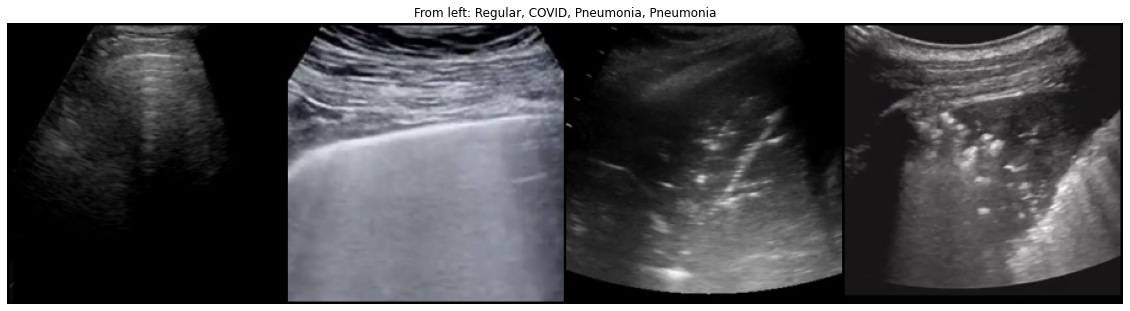

In [31]:
test_sample = get_sample_batch(sample_idx=3)

# Training the Model

### Training Procedure

- The model was **pre-trained** on Imagenet to extract image features such as shapes and textures. 
- All images are resized to **224 × 224** and fed through the convolutional layers of the model. 
- During training, **only the weights of the last three layers were fine-tuned**, while the other ones were frozen to the values from pre-training. 
- This results in a total of **2,392,963 trainable and 12,355,008 non-trainable parameters.**

In [14]:
trainer = Trainer()
model = trainer.start_training()

Epoch: 01
Time: 0m 19s
Train Loss: 1.040
Val   Loss: 0.879
----------------------------------------------------------------------------------------------------
Epoch: 02
Time: 0m 19s
Train Loss: 0.870
Val   Loss: 0.805
----------------------------------------------------------------------------------------------------
Epoch: 03
Time: 0m 19s
Train Loss: 0.768
Val   Loss: 0.748
----------------------------------------------------------------------------------------------------
Epoch: 04
Time: 0m 19s
Train Loss: 0.702
Val   Loss: 0.695
----------------------------------------------------------------------------------------------------
Epoch: 05
Time: 0m 19s
Train Loss: 0.654
Val   Loss: 0.662
----------------------------------------------------------------------------------------------------
Epoch: 06
Time: 0m 19s
Train Loss: 0.605
Val   Loss: 0.641
----------------------------------------------------------------------------------------------------
Epoch: 07
Time: 0m 19s
Train Loss: 0.575

# Loading a pre-trained model

Uncomment and execute the following cell to load a **pre-trained model**

In [10]:
#trainer = Trainer()
#trained_model = TrainedModel(model_name = MODEL_NAME)
#model = trained_model.loadModel()

# Evaluating the Model

In [11]:
images, true_labels, pred_labels, pred_probs = trainer.evaluate_model(proba=True)
metrics = Metrics(images, true_labels, pred_labels, pred_probs, trainer.classes)

Now, let us see how good our model is and plot the various metrics

## Confusion Matrix

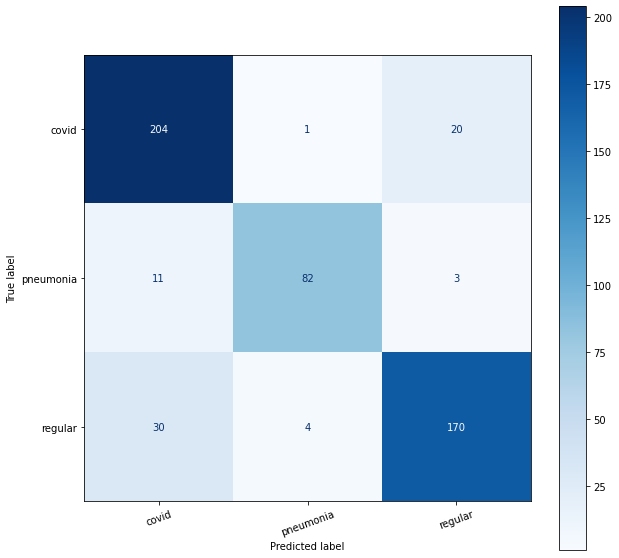

In [32]:
metrics.plot_confusion_matrix()

## Classification Report

In [19]:
print(metrics.get_classification_report())

              precision    recall  f1-score   support

       covid       0.83      0.91      0.87       225
   pneumonia       0.94      0.85      0.90        96
     regular       0.88      0.83      0.86       204

    accuracy                           0.87       525
   macro avg       0.89      0.86      0.87       525
weighted avg       0.87      0.87      0.87       525



## ROC Curve

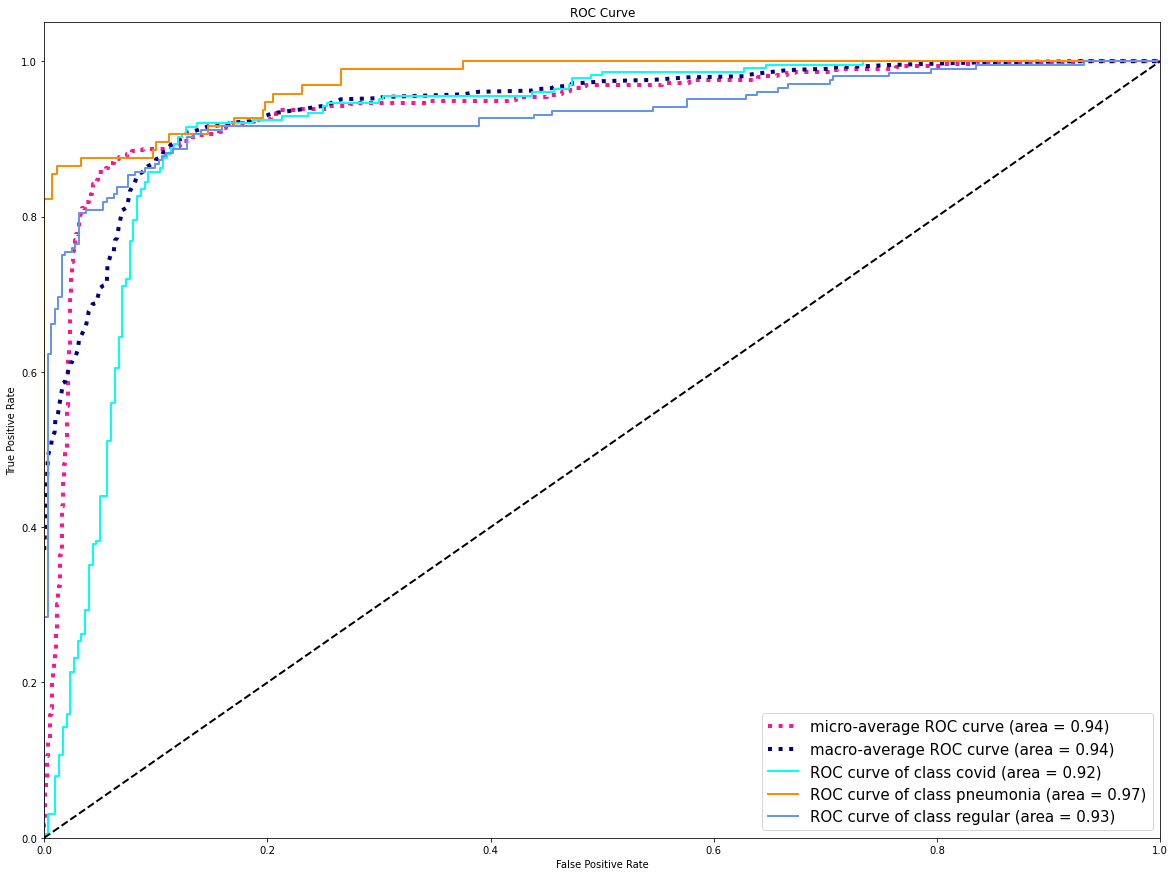

In [43]:
metrics.plot_roc_curve()

## Visualizing model predictions on a sample batch

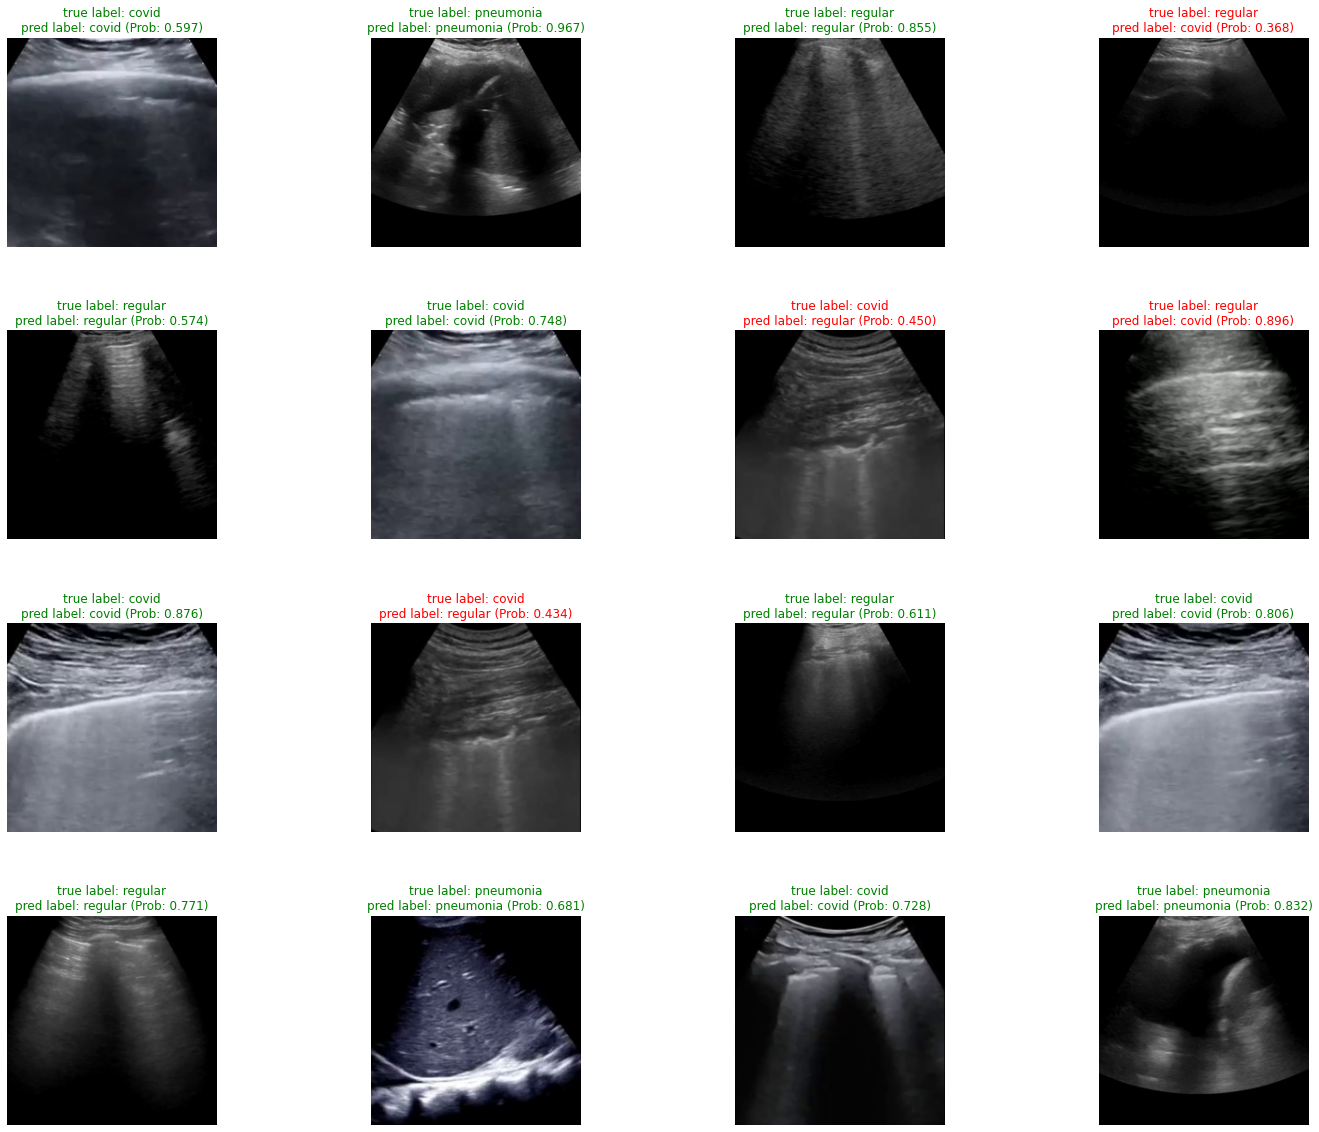

In [60]:
trainer.visualize_test_samples()

We have trained a model and evaluated it on the test set. **Let us now visualise different attributes of the model and try to understand the decision making process of the model to classify the images.**

# Visualization of model attributes

In [12]:
import sys
sys.path.append("util")
import vizutils

Following is the **image sample we will visualize the results on**

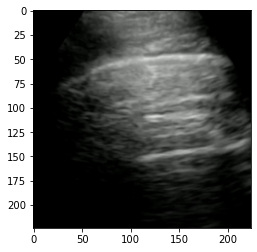

In [20]:
sample_images, sample_classes = test_sample[0], test_sample[1]
test_batch_idx = 3
plt.imshow(sample_images[test_batch_idx].detach().numpy().transpose(1,2,0))
plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'sample_visualisation_image.png'))
plt.show()

In [21]:
X = sample_images.cuda().detach()
y = sample_classes.cuda().detach()

## Saliency maps
Saliency maps are a quick way to tell **which part of the image influenced the classification decision** made by the network.

We will compute class saliency maps as described in Section 3.1 of [1].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

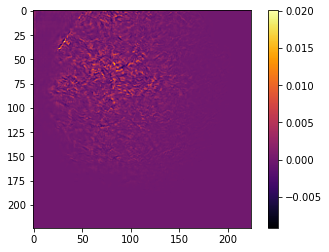

In [22]:
saliency = vizutils.compute_saliency_maps(X, y, 3, trainer.model)

saliency_np = saliency.cpu().numpy()
plt.imshow(saliency_np[test_batch_idx], cmap=plt.cm.inferno)
plt.colorbar()
plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'saliency_map.png'))
plt.show()

## Occlusion sensitivity maps

The occlusion sensitivity maps, based on Zeiler and Fergus [3],  **tell us how much the probability of the correct class changes when a square neighborhood centered at a particular pixel is occluded** (i.e. we cover that part of the image with a square of uniform color). 

[3] Zeiler, M.D. and Fergus, R., 2014, September. Visualizing and understanding convolutional networks. In European conference on computer vision (pp. 818-833). Springer, Cham. https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf 

In [66]:
sens_test_img = X[test_batch_idx,:,:,:].unsqueeze(dim=0)
sens_test_class = y[test_batch_idx].item()

In [67]:
sensitivity_map = vizutils.occlusion_sensitivy(sens_test_img, sens_test_class, model, stride=1, occ_val=0.185)

Row: 0
Row: 1
Row: 2
Row: 3
Row: 4
Row: 5
Row: 6
Row: 7
Row: 8
Row: 9
Row: 10
Row: 11
Row: 12
Row: 13
Row: 14
Row: 15
Row: 16
Row: 17
Row: 18
Row: 19
Row: 20
Row: 21
Row: 22
Row: 23
Row: 24
Row: 25
Row: 26
Row: 27
Row: 28
Row: 29
Row: 30
Row: 31
Row: 32
Row: 33
Row: 34
Row: 35
Row: 36
Row: 37
Row: 38
Row: 39
Row: 40
Row: 41
Row: 42
Row: 43
Row: 44
Row: 45
Row: 46
Row: 47
Row: 48
Row: 49
Row: 50
Row: 51
Row: 52
Row: 53
Row: 54
Row: 55
Row: 56
Row: 57
Row: 58
Row: 59
Row: 60
Row: 61
Row: 62
Row: 63
Row: 64
Row: 65
Row: 66
Row: 67
Row: 68
Row: 69
Row: 70
Row: 71
Row: 72
Row: 73
Row: 74
Row: 75
Row: 76
Row: 77
Row: 78
Row: 79
Row: 80
Row: 81
Row: 82
Row: 83
Row: 84
Row: 85
Row: 86
Row: 87
Row: 88
Row: 89
Row: 90
Row: 91
Row: 92
Row: 93
Row: 94
Row: 95
Row: 96
Row: 97
Row: 98
Row: 99
Row: 100
Row: 101
Row: 102
Row: 103
Row: 104
Row: 105
Row: 106
Row: 107
Row: 108
Row: 109
Row: 110
Row: 111
Row: 112
Row: 113
Row: 114
Row: 115
Row: 116
Row: 117
Row: 118
Row: 119
Row: 120
Row: 121
Row: 122
Row

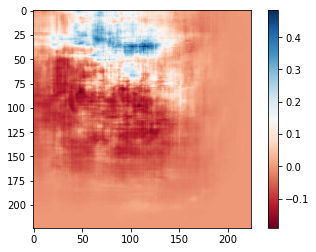

In [68]:
plt.imshow(sensitivity_map,cmap=plt.cm.RdBu)
plt.colorbar()
plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 'occlusion_sensitivity.png'))
plt.show()

## Class visualization 
We can synthesize an image to maximize the classification score of a particular class; **this can give us some sense of what the network is looking for when it classifies images of that class.**

By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [2] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [2] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [23]:
def shuffle_img_dims(img_from_torch):
    return img_from_torch.squeeze().permute(1, 2, 0)

In [24]:
def unshuffle_img_dims(img):
    return torch.unsqueeze(img.permute(2, 0, 1),dim=0)

As a preprocess, find the mean and standard deviation of the images:

In [25]:
# Calculating the dataset mean

dataset_mean = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float)

for i_batch, sample_batched in enumerate(dataloader):
    images_batch, classes_batch = sample_batched[0], sample_batched[1]
  
    N = images_batch.shape[0] # batch size
    H = images_batch.shape[2]
    W = images_batch.shape[3]
  
    mean_R = torch.sum(images_batch[:,0,:,:])/(H*W)
    mean_G = torch.sum(images_batch[:,1,:,:])/(H*W)
    mean_B = torch.sum(images_batch[:,2,:,:])/(H*W)

    dataset_mean[0] += mean_R
    dataset_mean[1] += mean_G
    dataset_mean[2] += mean_B

dataset_mean /= len(dataloader.dataset)

In [26]:
# Calculating the dataset std

dataset_var = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float)

for i_batch, sample_batched in enumerate(dataloader):
    images_batch, classes_batch = sample_batched[0], sample_batched[1]

    N = images_batch.shape[0] # batch size
    H = images_batch.shape[2]
    W = images_batch.shape[3]

    var_R = torch.sum(images_batch[:,0,:,:] - dataset_mean[0])**2/(H*W)
    var_G = torch.sum(images_batch[:,1,:,:] - dataset_mean[1])**2/(H*W)
    var_B = torch.sum(images_batch[:,2,:,:] - dataset_mean[2])**2/(H*W)

    dataset_var[0] += mean_R
    dataset_var[1] += mean_G
    dataset_var[2] += mean_B

dataset_var /= len(dataloader.dataset)
dataset_std = dataset_var**0.5

Now, use gradient ascent to find the "maximal activation image" for each class:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


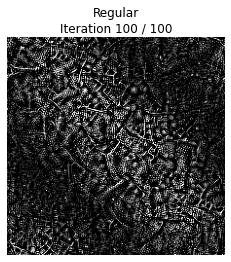

In [27]:
target_y = 2
out = vizutils.class_visualization(target_y, model, device, 
                                    num_classes=3, 
                                    channel_means=dataset_mean,
                                    channel_std_devs=dataset_std,
                                    deprocess_func=shuffle_img_dims,
                                    class_names_dict=lbl_map,
                                    savepath=os.path.join(OUTPUTS_SAVE_DIR, 'class_visualization.png'),
                                    monochrome=True)

Confirm that our "maximal activation" image activates our desired class a lot more than the other ones:

In [85]:
out_unshuffled = unshuffle_img_dims(out)
class_img_scores, _ = model(out_unshuffled.to(device))
class_img_scores

tensor([[-32.4330,  11.8167,  58.9739]], device='cuda:0',
       grad_fn=<AddmmBackward>)

## Visualization of Features using t-SNE

Based on example that can be found here: https://www.learnopencv.com/t-sne-for-feature-visualization/

t-SNE stands for **t-Distributed Stochastic Neighbor Embedding**

The main goal of t-SNE is to **project multi-dimensional points to 2- or 3-dimensional plots** so that if two points were close in the initial high-dimensional space, they stay close in the resulting projection. If the points were far from each other, they should stay far in the target low-dimensional space too.

To do that, **t-SNE first creates a probability distribution that captures these mutual distance relationships between the points in the initial high-dimensional space. After this, the algorithm tries to create a low-dimensional space that has similar relations between the points.**

It’s essentially an optimization problem — and the algorithm uses Stochastic Gradient Descent to solve it. As a cost function, it uses **Kullback–Leibler divergence** — a commonly used measure of how different two data distributions are.

In [109]:
train_path_data, test_path_data = trainer.get_train_test_info()
train_loader, test_loader = trainer.get_train_test_loaders()

In [110]:
features = np.zeros((1,64))
labels_t = np.array([0])
paths_t = []

for i, batch in enumerate(test_loader):
    
    inputs = batch[0].to(device)
    labels = batch[1]
    paths_t.append(batch[2])
    
    
    output = model(inputs)[1].cpu().detach().numpy()
    
    current_outputs = output
    features = np.concatenate((features, current_outputs))
    
    current_labels = labels.cpu().detach().numpy()
    labels_t = np.concatenate((labels_t, current_labels))

features = features[1:,]
labels_t = labels_t[1:,]
paths_t = list(itertools.chain(*paths_t))

In [111]:
tsne = TSNE(n_components=2).fit_transform(features)

In [112]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [113]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

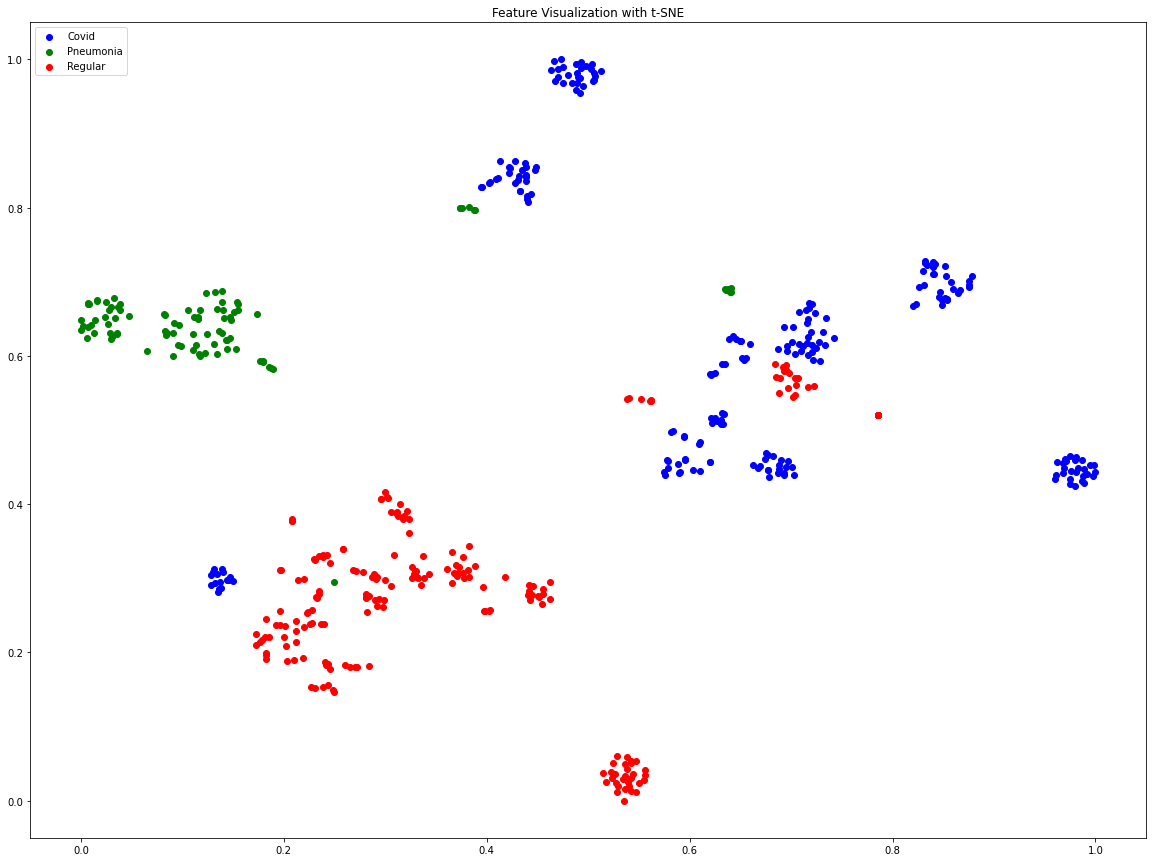

In [114]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)

for i in range(len(trainer.classes)):
    
    if i == 0:
        color = 'blue'
        label = 'Covid'
    elif i == 1:
        color = 'green'
        label = 'Pneumonia'
    else:
        color = 'red'
        label = 'Regular'
        
    # find the samples of the current class in the data
    indices = np.where(labels_t == i)[0]
    
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label='{0}'
               ''.format(label))
    
# build a legend using the labels we set previously
ax.legend(loc='upper left')
plt.title("Feature Visualization with t-SNE")
plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 't-SNE_visualisation.png'))
plt.show()

## t-SNE visualization with images

In [115]:
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

In [116]:
def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color, 5)

    return image

In [117]:
# Compute the coordinates of the image on the plot
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

In [118]:
def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in zip(images, labels, tx, ty):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)
        
        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.figure(figsize=(20,15))
    plt.imshow(tsne_plot[:, :, ::-1])
    
    red_patch = mpatches.Patch(color='red', label='Regular')
    blue_patch = mpatches.Patch(color='green', label='Pneumonia')
    green_patch = mpatches.Patch(color='blue', label='Covid')

    plt.legend(handles=[red_patch, blue_patch, green_patch])
    
    plt.savefig(os.path.join(OUTPUTS_SAVE_DIR, 't-SNE_visualisation_with_images.png'))
    
    plt.show()

In [119]:
colors_per_class = {0:(255,0,0), 1:(0,255,0), 2:(0,0,255)}

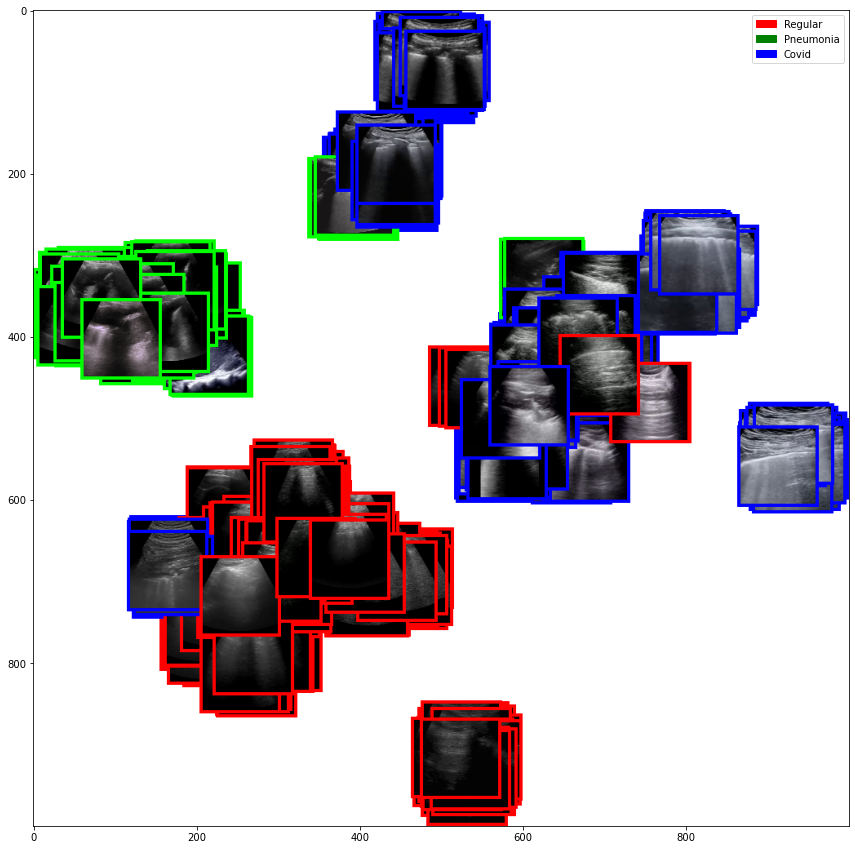

In [120]:
visualize_tsne_images(tx, ty, paths_t, labels_t)